In [3]:
from os import listdir
from os.path import isfile, join
import json
import seaborn as sns
import pandas as pd

In [19]:
def process_json(json):
    if json["input"]["consensus"] == "Narwhal":
        cate = json["input"]["consensus"] + str(json["input"]["parameters"]["batch_size"]) + str(json["input"]["parameters"]["transaction_size"])
        if "delay" in json["input"]:
            cate += str(json["input"]["delay"])
        row = {
        "cate": [cate],
        "rate" : json["input"]["client"]["injection_rate"],
        "latency": [json["output"]["latency"]],
        "throughput": [json["output"]["throughput"]],
        }
        return pd.DataFrame(row)
    if json["input"]["consensus"] != "HotStuff":
        json["input"]["consensus"] = "Jasmine"
    cate = json["input"]["consensus"] + str(json["input"]["node_settings"]["batch_size"]) + str(json["input"]["node_settings"]["transaction_size"]) + \
       str(json["input"]["node_settings"]["leader_rotation"]) + \
       str(len(json["input"]["peer_addrs"]))
    row = {
        "cate": [cate],
        "consensus-latency":[json["output"]["average_delay"]],
        "rate" : json["input"]["client"]["injection_rate"],
        "latency": [json["output"]["e2e_delay"]],
        "throughput": [json["output"]["consensus_throughput"]],
    }
    return pd.DataFrame(row)

def process_dir(dir, disable_jasmine=False): 
    fs = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    fs = [join(mypath, f) for f in fs if f.startswith('result')]
    fs
    df = pd.DataFrame()

    for f in fs:
        with open(f) as file:
            data = json.load(file)
        r = process_json(data)

        df = pd.concat([df, r])

    df = df.sort_values(by=["cate", "rate"])
    if disable_jasmine:
        df = df[df['cate'].str.startswith('HotStuff')]
    # df

    # Plot the lines on two facets
    # Define the palette as a list to specify exact values

    return sns.lineplot(
        data=df,
        x="throughput", y="latency",sort=False,
        hue="cate",
    ), df

<AxesSubplot:xlabel='throughput', ylabel='latency'>

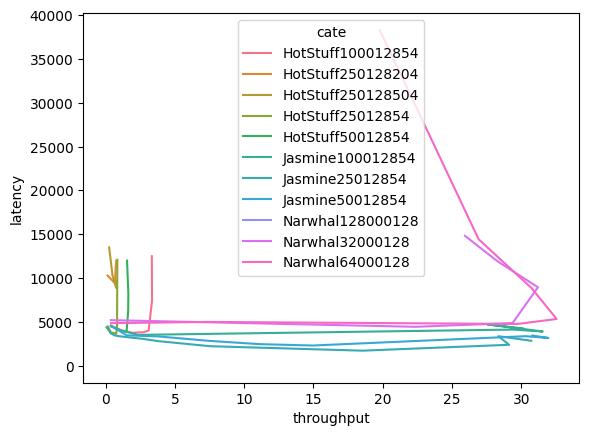

In [25]:
mypath = "./1-plans"
pic, data = process_dir(mypath)
pic

In [11]:
data

,cate,consensus-latency,rate,latency,throughput
0,HotStuff100012854,1023.613740,100,4534.946663,0.388850
0,HotStuff100012854,1024.240376,300,4052.167245,1.166461
0,HotStuff100012854,1019.729331,400,3922.195622,1.549494
0,HotStuff100012854,995.624560,500,3767.781077,1.938537
0,HotStuff100012854,991.235032,600,3821.287401,2.333929
...,...,...,...,...,...
0,Narwhal,NaN,1000,5016.000000,7.406000
0,Narwhal,NaN,2000,0.000000,0.000000
0,Narwhal,NaN,2000,4.783000,29.720000
0,Narwhal,NaN,10000,8.885000,30.734000


<AxesSubplot:xlabel='throughput', ylabel='latency'>

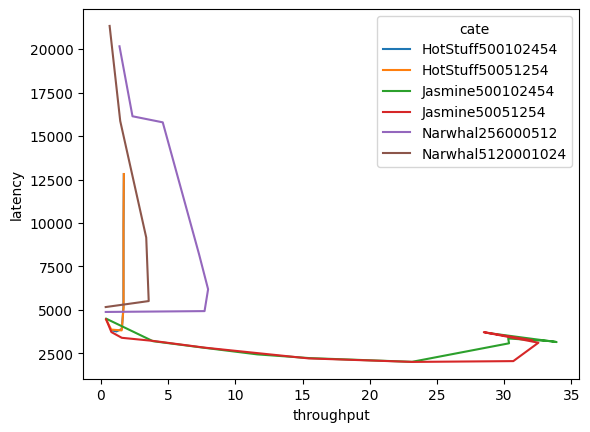

In [33]:
mypath = "./2-plans"
pic, data = process_dir(mypath)
pic

In [292]:
data

,cate,consensus-latency,rate,latency,throughput
0,HotStuff500102454,1003.194932,200,3830.428784,0.767266
0,HotStuff500102454,981.762440,300,3768.419905,1.155755
0,HotStuff500102454,968.851401,400,3909.417103,1.554501
0,HotStuff500102454,947.500145,450,5160.222638,1.672443
0,HotStuff500102454,947.346040,500,9758.111732,1.679786
0,HotStuff500102454,949.055416,5000,12808.655122,1.702143
0,HotStuff50051254,1008.493541,100,4445.275344,0.386284
0,HotStuff50051254,1010.721802,200,3871.439822,0.766874
0,HotStuff50051254,954.133009,400,3825.918364,1.543263
0,HotStuff50051254,960.606919,450,5137.764232,1.682726


<AxesSubplot:xlabel='throughput', ylabel='latency'>

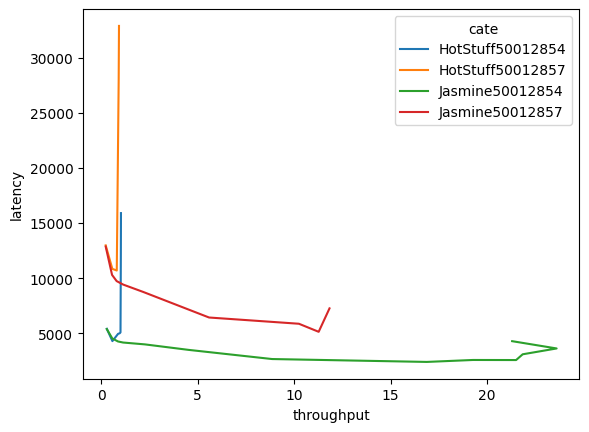

In [380]:
mypath = "./4-plan"
pic, data = process_dir(mypath)
pic

In [381]:
data

,cate,consensus-latency,rate,latency,throughput
0,HotStuff50012854,1108.406388,100,5406.423907,0.290615
0,HotStuff50012854,1105.836670,200,4292.750370,0.580596
0,HotStuff50012854,1484.968290,300,4948.710906,0.872626
0,HotStuff50012854,1464.861644,350,5005.080140,0.960574
0,HotStuff50012854,1441.741803,375,5085.357946,0.999533
0,HotStuff50012854,1433.774932,400,12034.972472,1.017269
0,HotStuff50012854,1430.281554,600,15277.043659,1.023282
0,HotStuff50012854,1438.107299,4000,15879.972900,1.023754
0,HotStuff50012854,1439.901718,6000,15899.257176,1.023639
0,HotStuff50012857,1131.202806,50,12974.115136,0.232134


<AxesSubplot:xlabel='throughput', ylabel='latency'>

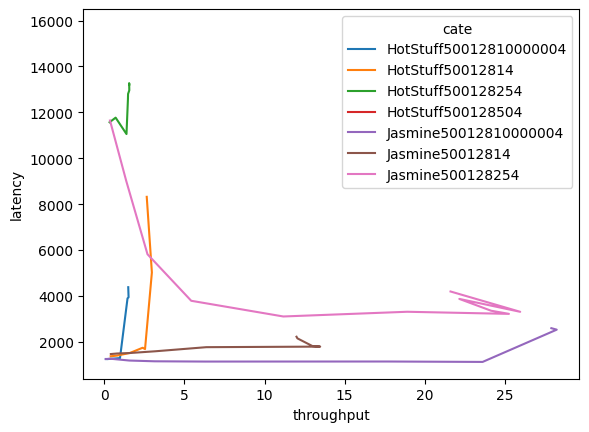

In [438]:
mypath = "./5-plan"
pic, data = process_dir(mypath)
pic

In [387]:
data

,cate,consensus-latency,rate,latency,throughput
0,HotStuff50012810000004,933.853186,100,1248.880886,0.095241
0,HotStuff50012810000004,940.746601,200,1245.264524,0.195708
0,HotStuff50012810000004,952.333741,400,1260.383863,0.390985
0,HotStuff50012810000004,954.765510,800,1277.716351,0.784443
0,HotStuff50012810000004,953.836735,1000,1290.852608,0.979238
0,HotStuff50012810000004,1016.805282,1500,3893.763329,1.449258
0,HotStuff50012810000004,940.572301,2000,3938.566191,1.514684
0,HotStuff50012810000004,952.598097,200000,4379.659590,1.493998
0,HotStuff50012814,666.166027,100,1369.056900,0.399214
0,HotStuff50012814,678.757128,200,1398.768366,0.792788


<AxesSubplot:xlabel='throughput', ylabel='latency'>

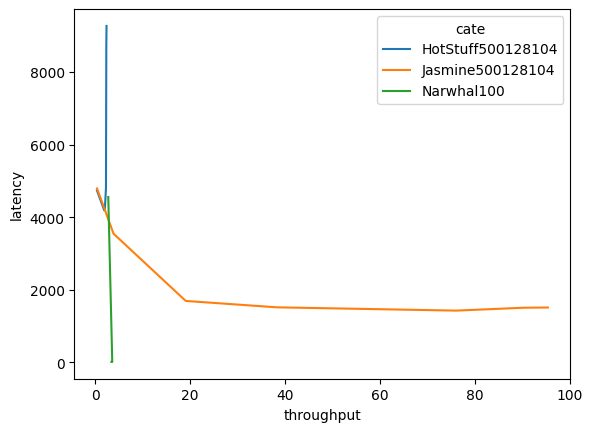

In [466]:
mypath = "./3-plan"
pic, data = process_dir(mypath)
pic